In [14]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from scipy.misc import imread
import pickle
import cv2
import seaborn as sns

In [15]:
%matplotlib inline
sns.set_context("poster")

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


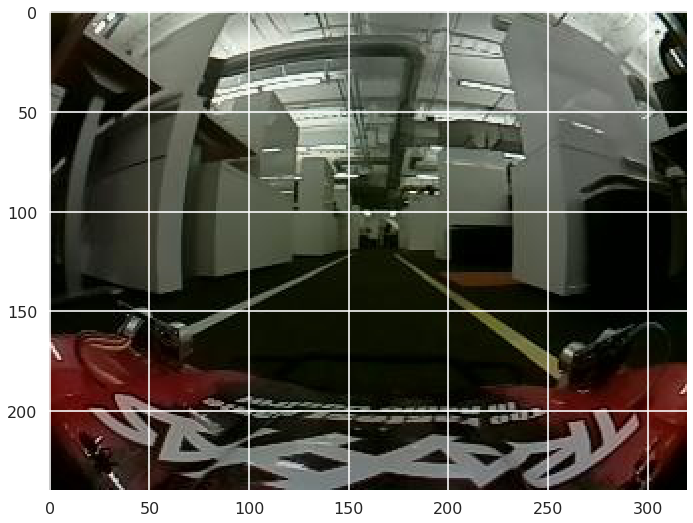

In [79]:
img = imread("data/run_4/100.jpg")
plt.imshow(img)


In [80]:
folder_to_process = "run_4"

In [81]:
# this file is used to process the raw output of recording training data from the simulator
# and prepare it for uploading to the AWS GPU


print("Processing ", folder_to_process)


def extract_data(folder):
    X = [] #images
    XX = [] #senor data (aka speed in this case)
    y = [] #actual steering angles (throttle in the future)


    with open('data/{}/_data.csv'.format(folder_to_process)) as f:
        reader = csv.reader(f)
        print(''.join(next(reader)))
        for line in reader:
            line = ''.join(line).split('|')
            img_file= "{}".format(int(line[0]))
            img = imread('data/{}/{}.jpg'.format(folder_to_process, img_file))
            
            print
            X.append(img)
            #index 8 - throttle is -100 to 100
            #index 7 - rpm is 5000ish max
            XX.append([float(line[7])/5000, float(line[8])/100]) 
            y.append([float(line[5])/45.0]) # steering is -45 to 45

    return (np.array(X), np.array(XX), np.array(y))


X_train, XX_train, y_train = extract_data(folder_to_process)

print("--done--")

Processing  run_4
image_id|ACC|MAG|UFL|GYR|STR|UFR|RPM|THR|PRH|time
--done--


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


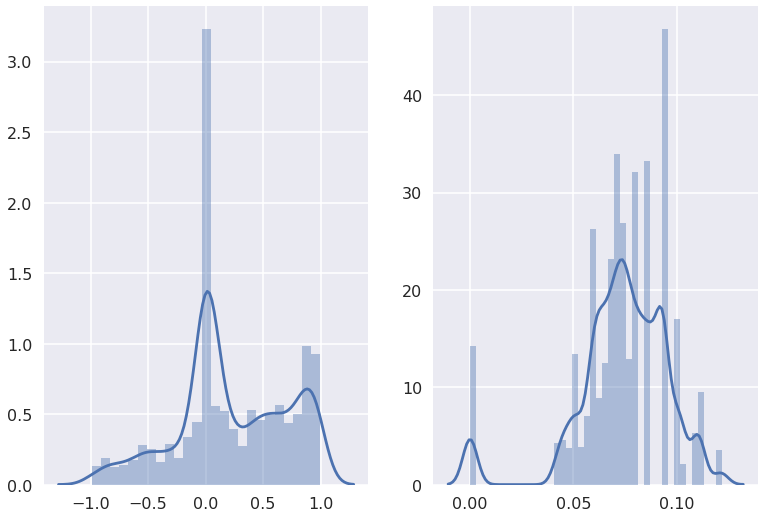

In [82]:
plt.subplot(1,2,1)
sns.distplot(y_train)
plt.subplot(1,2,2)
sns.distplot(XX_train[:,0])

In [83]:
#bring in camera calibration matrix
with open('../camera_calibration/fisheye_f1p8_camera_calibration.pkl', 'rb') as f:
    calibration = pickle.load(f)
mtx = calibration["mtx"]
dist = calibration["dist"]

def pipeline(image):
    #undistort it
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    output = undistort[100:180,:,:]
    return  output

(240, 320, 3)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


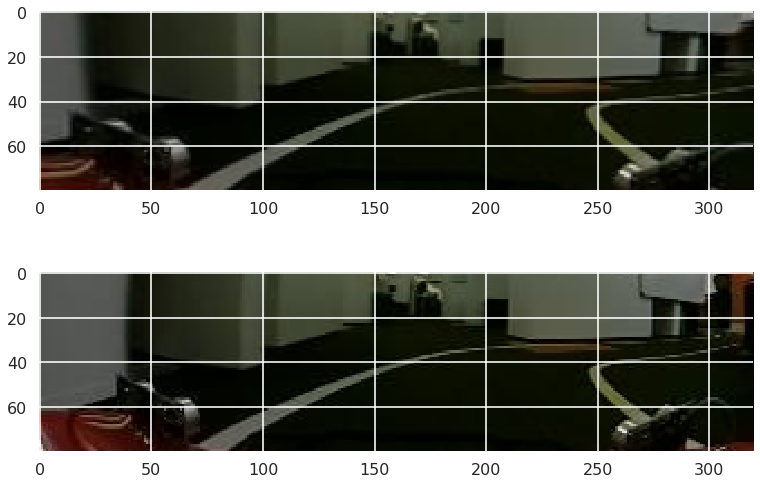

In [84]:
x = X_train[300]
print(x.shape)
plt.subplot(2,1,1)
plt.imshow(pipeline(x))
plt.subplot(2,1,2)
plt.imshow(x[100:180,:,:])

In [85]:
#reduce image to the road section and apply any transforms in the pipeline
X_train = np.array([pipeline(x) for x in X_train])

In [86]:
X_train.shape

(3624, 80, 320, 3)

In [87]:
# the following section was used to scrub through the video and find bad sections and remove them
current_frame = 0
scroll_rate = 10

Current Frame:  0 Steering [ 0.] rpm [ 0.  0.]


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


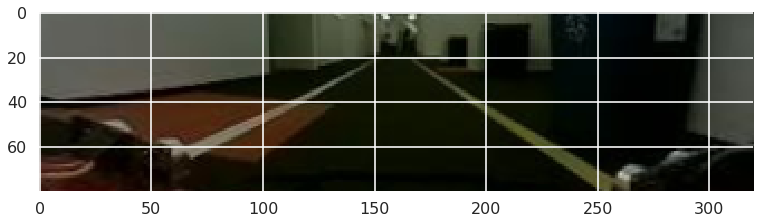

In [88]:
#scrub through thismanually for bad frames.... ouch time consuming
print("Current Frame: ", current_frame, "Steering", y_train[current_frame], "rpm", XX_train[current_frame] )
plt.imshow(X_train[current_frame])
current_frame += scroll_rate



In [89]:
#drop bad frames
## bag 1
data_frames_to_drop = [(0,200), (-300, -1)]


clean_indicies = np.ones(len(X_train))
for r in data_frames_to_drop:
    clean_indicies[r[0]:r[1]] = 0

In [90]:
X_cleaned = X_train[clean_indicies.astype(np.bool)]
XX_cleaned = XX_train[clean_indicies.astype(np.bool)]
y_cleaned = y_train[clean_indicies.astype(np.bool)]

print(X_cleaned.shape,XX_cleaned.shape, y_cleaned.shape)

data = {
    "images": X_cleaned,
    "sensors": XX_cleaned,
    "steering_throttle": y_cleaned
}

(3125, 80, 320, 3) (3125, 2) (3125, 1)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


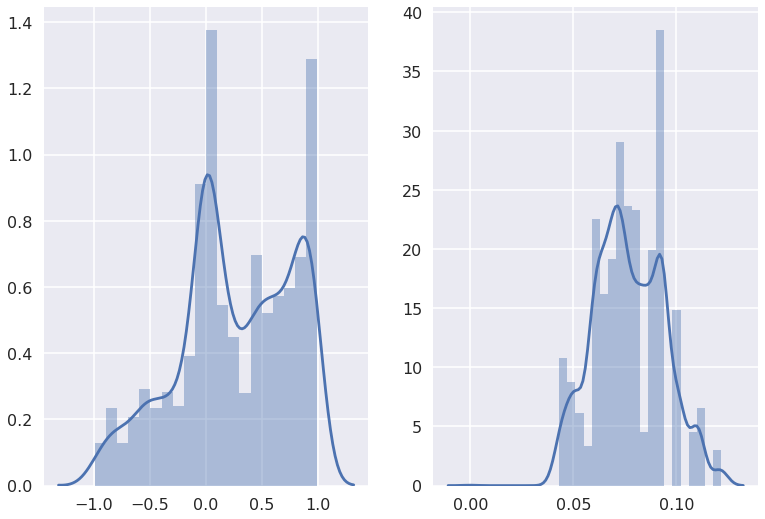

In [91]:
plt.subplot(1,2,1)
sns.distplot(y_cleaned)
plt.subplot(1,2,2)
sns.distplot(XX_cleaned[:,0])

In [92]:
with open('V79_run_{}.pkl'.format(folder_to_process), 'wb') as f:
    pickle.dump(data, f)